In [ ]:
!pip install optuna
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd

import time
from tqdm import tqdm
from functools import partial
from optuna import create_study

from sklearn import svm
from sklearn import impute
from sklearn import cluster
from sklearn import metrics
from sklearn import ensemble
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import decomposition
from sklearn import model_selection

from scipy import stats
from optuna import create_study
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [ ]:
# Load the dataset

bank_data = pd.read_csv("/content/drive/MyDrive/Projects/Data science projects/Bank loan prediction model/Bank_Personal_Loan_Modelling.csv").drop("ID", axis="columns")

print(bank_data.shape)

bank_data.head()

(5000, 13)


,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [ ]:
# Display the information about the dataset
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIP Code            5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal Loan       5000 non-null   int64  
 9   Securities Account  5000 non-null   int64  
 10  CD Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 507.9 KB


In [ ]:
# Display the statistical information about the dataset
bank_data.describe()[1:]

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
mean,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [ ]:
# Check for the number of unique values in each column
bank_data.nunique()

Age                    45
Experience             47
Income                162
ZIP Code              467
Family                  4
CCAvg                 108
Education               3
Mortgage              347
Personal Loan           2
Securities Account      2
CD Account              2
Online                  2
CreditCard              2
dtype: int64

In [ ]:
# Check for null value
bank_data.isnull().sum()

Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

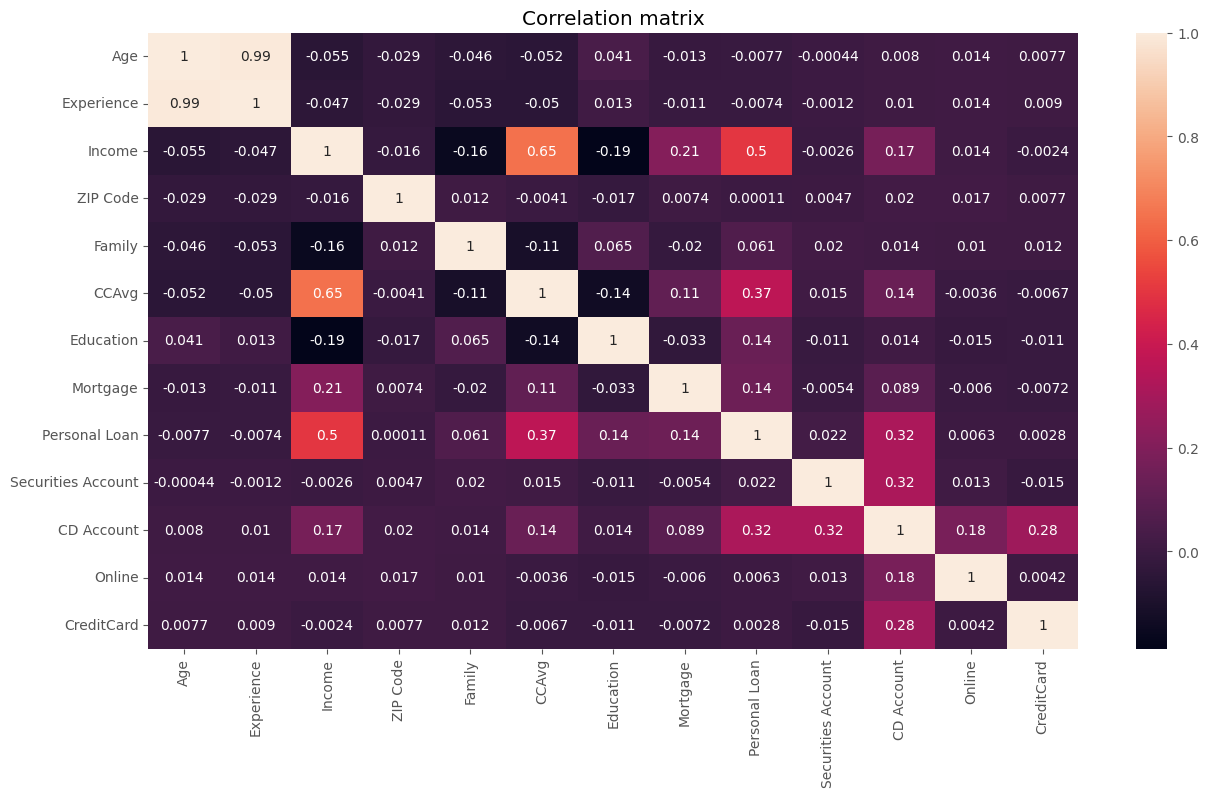

In [ ]:
# Check for correlation
plt.figure(figsize=(15, 8))
sns.heatmap(bank_data.corr(), annot=True)
plt.title("Correlation matrix")
plt.show()

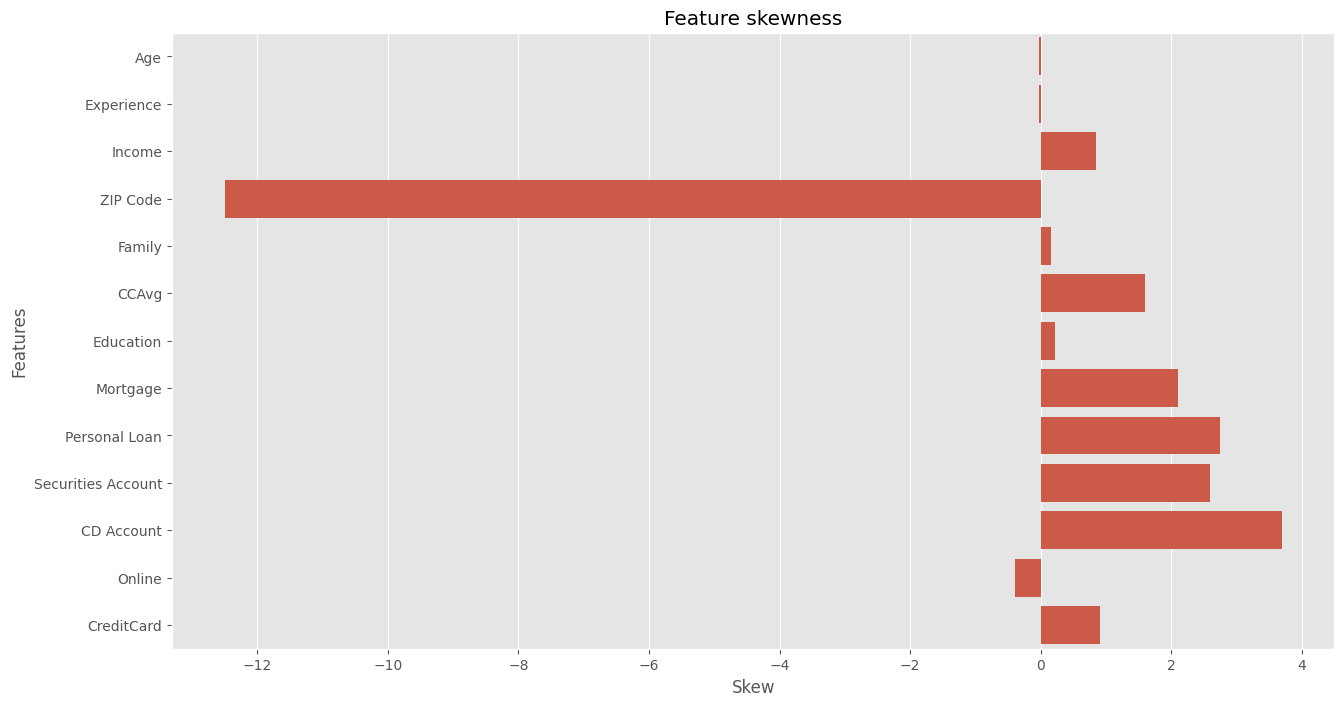

In [ ]:
# Check for skewness in dataset
skewness = bank_data.skew()

plt.figure(figsize=(15, 8))
barplot = sns.barplot(x=skewness.values, y=skewness.index)
barplot.set_xlabel("Skew")
barplot.set_ylabel("Features")
barplot.set_title("Feature skewness")
plt.show()

In [ ]:
def p_value_test(c1, c2, category):
    if category == "numeric":
        t, p = stats.ttest_ind(a=bank_data[c1], b=bank_data[c2])

        if p < 0.05:
            print(f"There's a significant difference in the mean of {c1} and {c2}")
        else:
            print(f"There's no significant difference in the mean of {c1} and {c2}")
    else:
        crosstab = pd.crosstab(index=bank_data[c1], columns=bank_data[c2])
        _, p, _, _ = stats.chi2_contingency(crosstab)

        if p < 0.05:
            print(f"There's a significant difference in the mean of {c1} and {c2}")
        else:
            print(f"There's no significant difference in the mean of {c1} and {c2}")

In [ ]:
p_value_test("CCAvg", "Income", "numeric")

There's a significant difference in the mean of CCAvg and Income


In [ ]:
p_value_test("CD Account", "Online", "categorical")

There's a significant difference in the mean of CD Account and Online


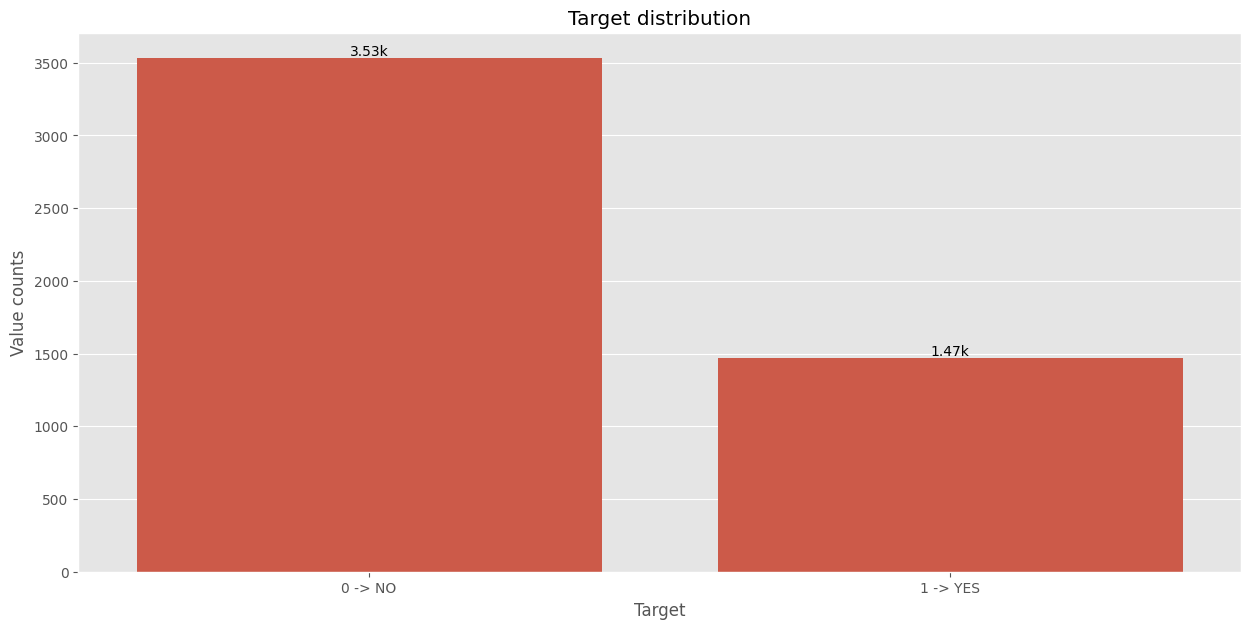

In [ ]:
# Target distribution
target_dist = bank_data["CreditCard"].value_counts()

plt.figure(figsize=(15, 7))
barplot = sns.barplot(x=target_dist.index, y=target_dist.values)
# Add values to the top of the bar
for p in barplot.patches:
    h = p.get_height()
    barplot.text(p.get_x()+(p.get_width()/2), h, f"{h/1000}k", ha="center", va="bottom")

barplot.set_xticklabels(["0 -> NO", "1 -> YES"])
barplot.set_xlabel("Target")
barplot.set_ylabel("Value counts")
barplot.set_title("Target distribution")
plt.show()

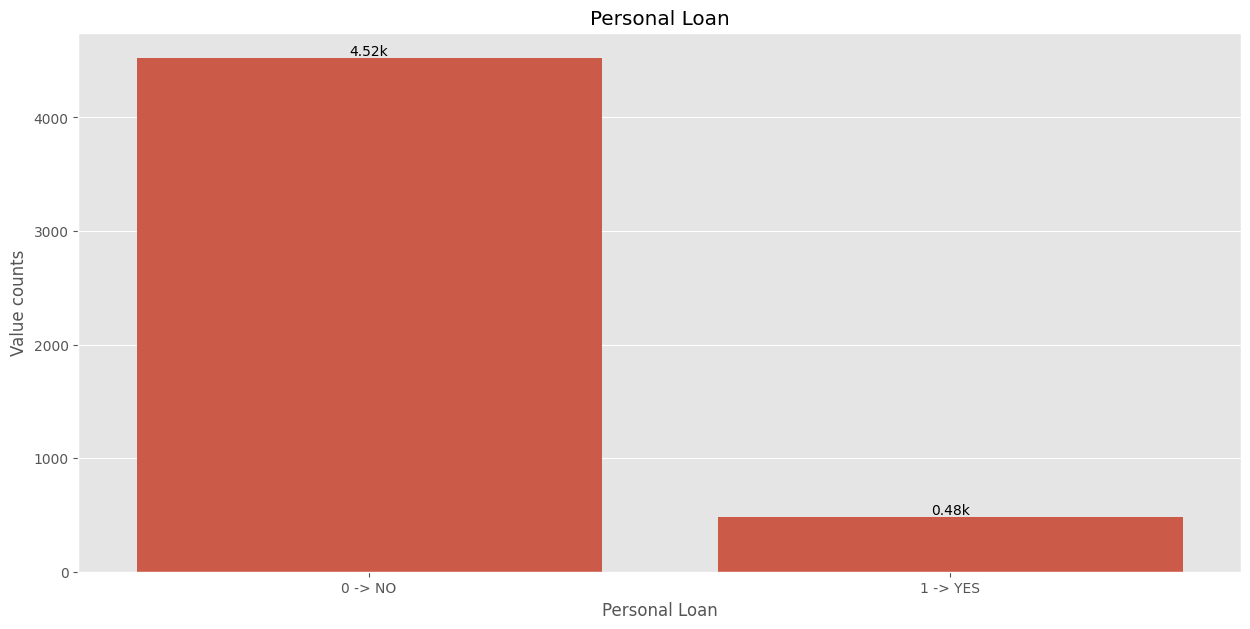

In [ ]:
personal_Loan_dist = bank_data["Personal Loan"].value_counts()

plt.figure(figsize=(15, 7))
barplot = sns.barplot(x=personal_Loan_dist.index, y=personal_Loan_dist.values)

# Add values to the top of the bar
for p in barplot.patches:
    h = p.get_height()
    barplot.text(p.get_x()+(p.get_width()/2), h, f"{h/1000}k", ha="center", va="bottom")

barplot.set_xticklabels(["0 -> NO", "1 -> YES"])
barplot.set_xlabel("Personal Loan")
barplot.set_ylabel("Value counts")
barplot.set_title("Personal Loan")
plt.show()

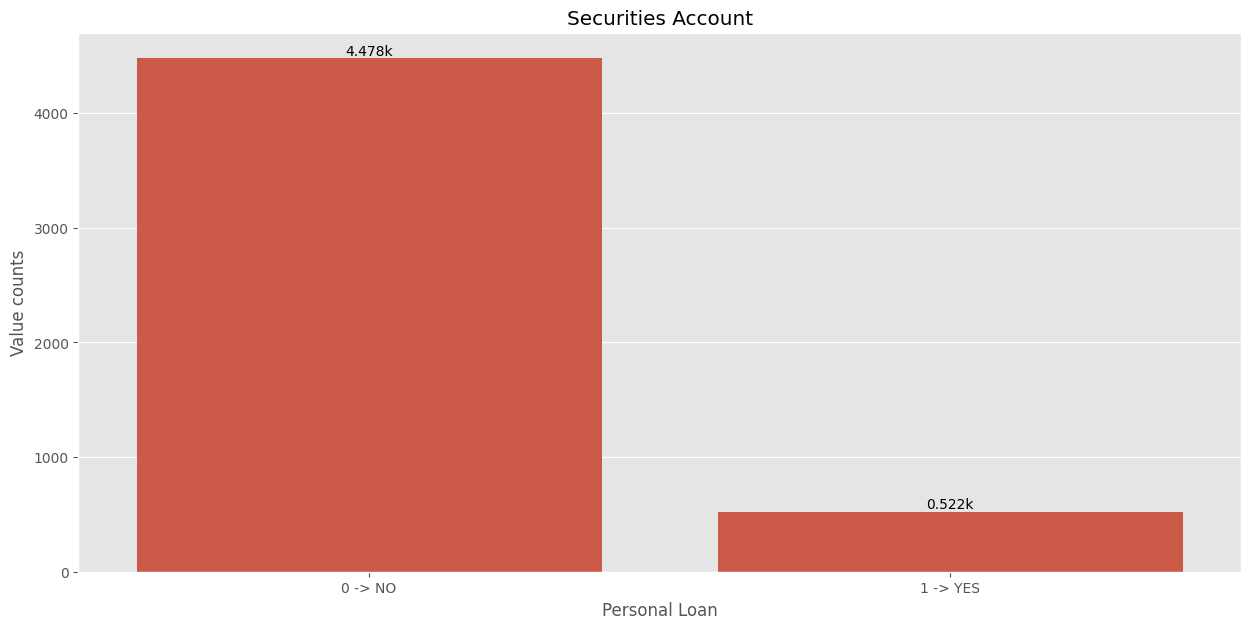

In [ ]:
securities_account_dist = bank_data["Securities Account"].value_counts()

plt.figure(figsize=(15, 7))
barplot = sns.barplot(x=securities_account_dist.index, y=securities_account_dist.values)

# Add values to the top of the bar
for p in barplot.patches:
    h = p.get_height()
    barplot.text(p.get_x()+(p.get_width()/2), h, f"{h/1000}k", ha="center", va="bottom")

barplot.set_xticklabels(["0 -> NO", "1 -> YES"])
barplot.set_xlabel("Personal Loan")
barplot.set_ylabel("Value counts")
barplot.set_title("Securities Account")
plt.show()

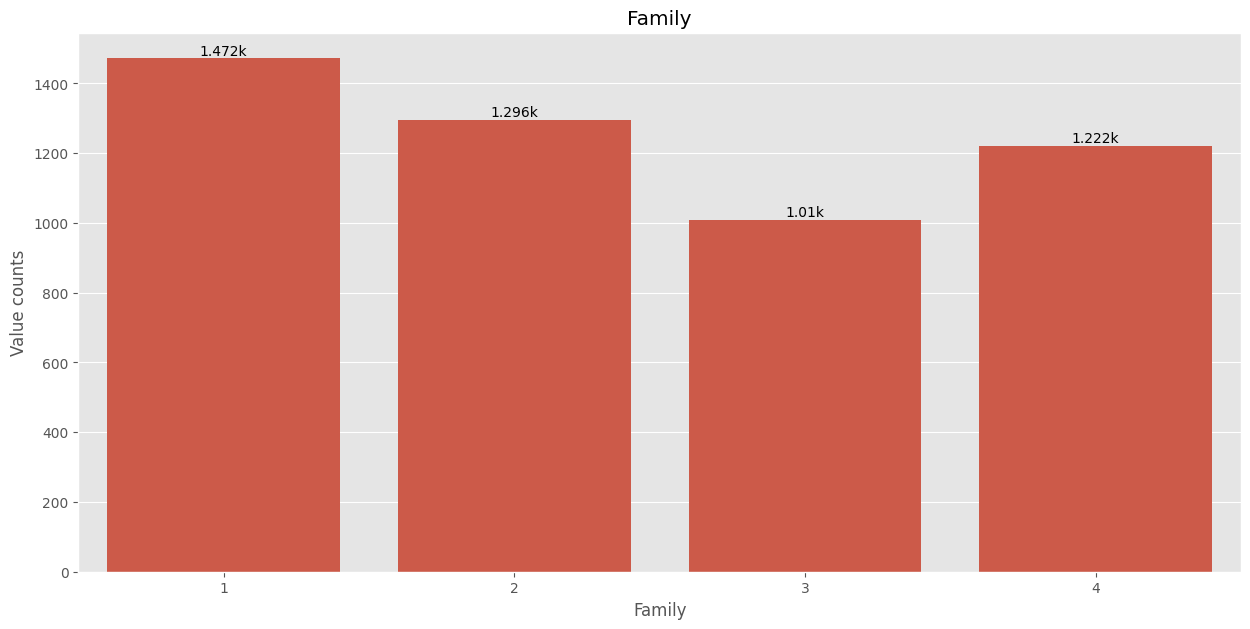

In [ ]:
family_dist = bank_data["Family"].value_counts()

plt.figure(figsize=(15, 7))
barplot = sns.barplot(x=family_dist.index, y=family_dist.values)

# Add values to the top of the bar
for p in barplot.patches:
    h = p.get_height()
    barplot.text(p.get_x()+(p.get_width()/2), h, f"{h/1000}k", ha="center", va="bottom")

barplot.set_xlabel("Family")
barplot.set_ylabel("Value counts")
barplot.set_title("Family")
plt.show()

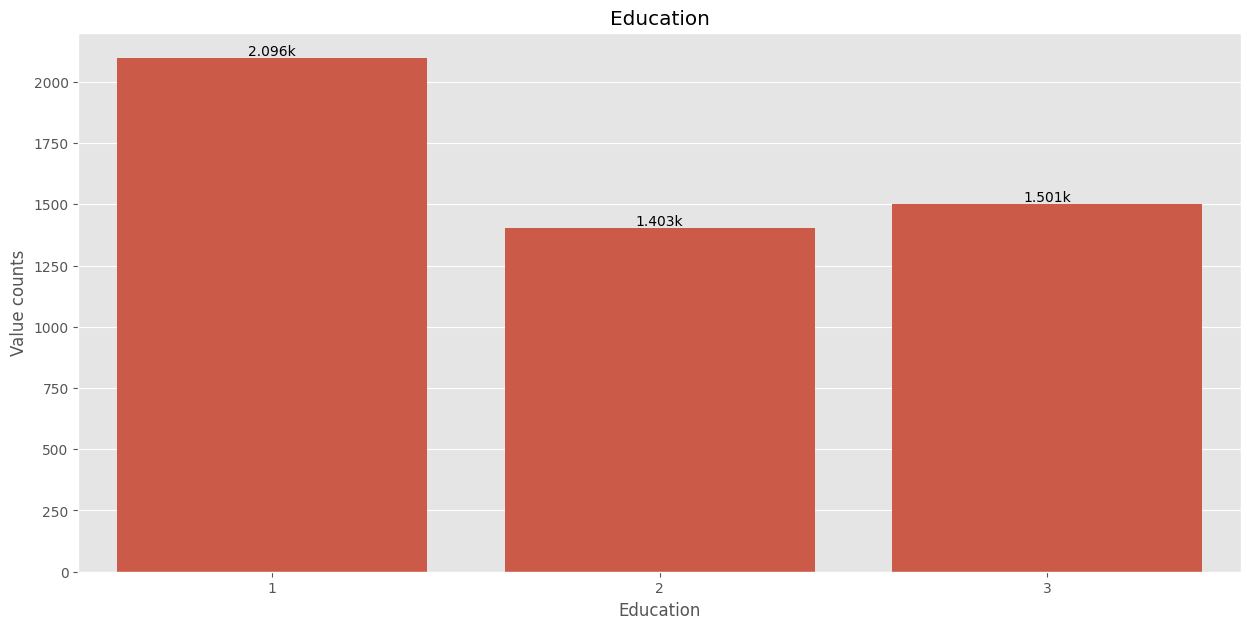

In [ ]:
education_dist = bank_data["Education"].value_counts()

plt.figure(figsize=(15, 7))
barplot = sns.barplot(x=education_dist.index, y=education_dist.values)

# Add values to the top of the bar
for p in barplot.patches:
    h = p.get_height()
    barplot.text(p.get_x()+(p.get_width()/2), h, f"{h/1000}k", ha="center", va="bottom")

barplot.set_xlabel("Education")
barplot.set_ylabel("Value counts")
barplot.set_title("Education")
plt.show()

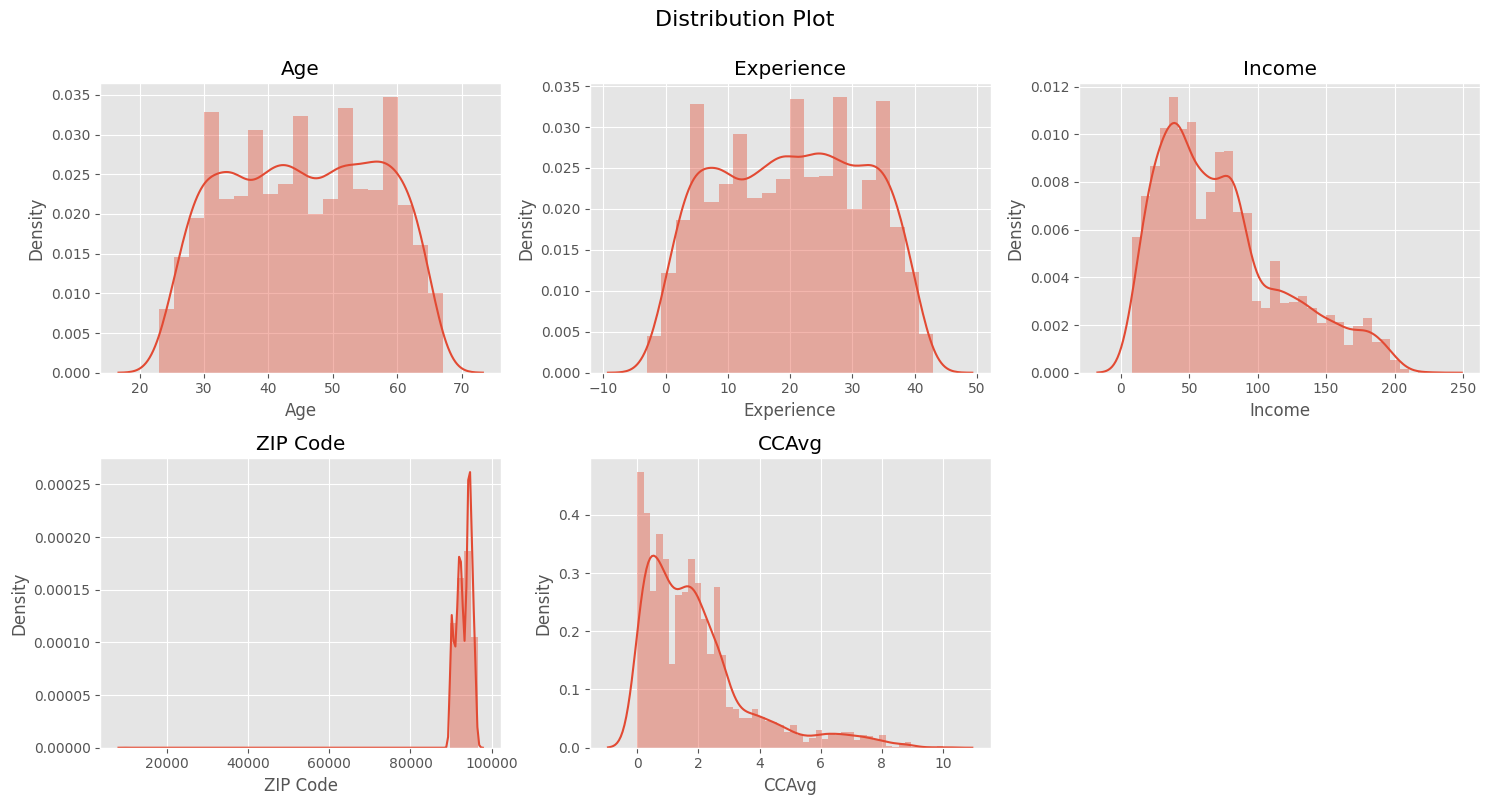

In [ ]:
num_col = ["Age", "Experience", "Income", "ZIP Code", "CCAvg"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()
for idx, col in enumerate(num_col):
    displot = sns.distplot(bank_data[col], ax=axes[idx])
    displot.set_title(col)

# Delete remaining axes
for r_a in axes[len(num_col):]:
    fig.delaxes(r_a)

fig.suptitle("Distribution Plot", fontsize=16, y=1)
plt.tight_layout()
plt.show()

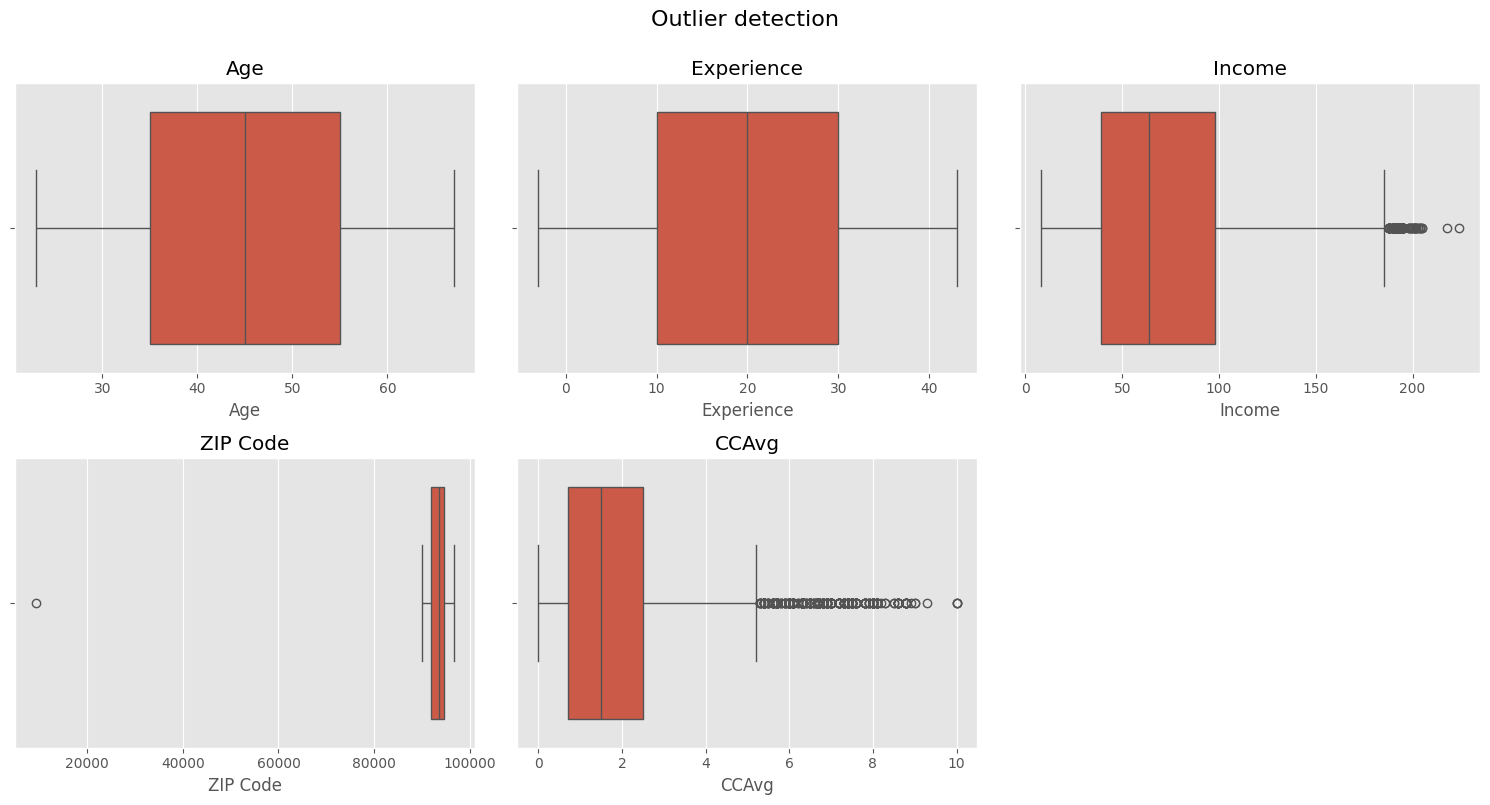

In [ ]:
num_col = ["Age", "Experience", "Income", "ZIP Code", "CCAvg"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()
for idx, col in enumerate(num_col):
    boxplot = sns.boxplot(x=bank_data[col], ax=axes[idx])
    boxplot.set_title(col)

# Delete remaining axes
for r_a in axes[len(num_col):]:
    fig.delaxes(r_a)

# Add subtitle
fig.suptitle("Outlier detection", fontsize=16, y=1)
plt.tight_layout()
plt.show()

### Modelling

In [ ]:
X = bank_data.drop("CreditCard", axis="columns")
# Scale features
X = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X), columns=X.columns)
y = bank_data["CreditCard"]

#### Ensembing technique

In [ ]:
def timer(function):
    def wrapper(*x, **y):
        start_time = time.time()
        func = function(*x, **y)
        time_diff = time.time() - start_time
        print(f"Execution time: {time_diff}")
        return func
    return wrapper

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.05, random_state=0)

In [ ]:
@timer
def ensemble_model(X, y, X_val, y_val, list_of_model, n_splits):
    trained_models = {}
    pred_per_model = pd.DataFrame()
    kfold = model_selection.StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)

    for model in list_of_model:
        if model.__name__ == "XGBClassifier":
            init_model = model(verbosity=0)
        elif model.__name__ == "LGBMClassifier":
            init_model = model(verbose=-1)
        elif model.__name__ == "CatBoostClassifier":
            init_model = model(silent=True)
        else:
            init_model = model()

        test_pred = pd.DataFrame()
        for idx, (train_idx, test_idx) in tqdm(enumerate(kfold.split(X, y)), total=n_splits, desc=f"Training {model.__name__}"):
            xtrain, xtest = X.iloc[train_idx], X.iloc[test_idx]
            ytrain, ytest = y.iloc[train_idx], y.iloc[test_idx]

            init_model.fit(xtrain, ytrain)

            test_pred[f"kfold {idx}"] = init_model.predict(X_val.reset_index(drop=True))


        pred_per_model[model.__name__] = test_pred.mode(axis=1)[0]

        trained_models[f"{model.__name__}"] = init_model

    final_pred = pred_per_model.mode(axis=1)[0]

    print(f"Accuracy score: {metrics.accuracy_score(y_val.reset_index(drop=True), final_pred)}")

    return trained_models

In [ ]:
list_of_models = [ensemble.RandomForestClassifier, naive_bayes.GaussianNB, XGBClassifier, CatBoostClassifier, LGBMClassifier]

In [ ]:
trained_models = ensemble_model(x_train, y_train, x_test, y_test, list_of_models, 5)

Training LGBMClassifier: 100%|██████████| 5/5 [00:00<00:00,  8.69it/s]


Accuracy score: 0.812
Execution time: 50.24313569068909


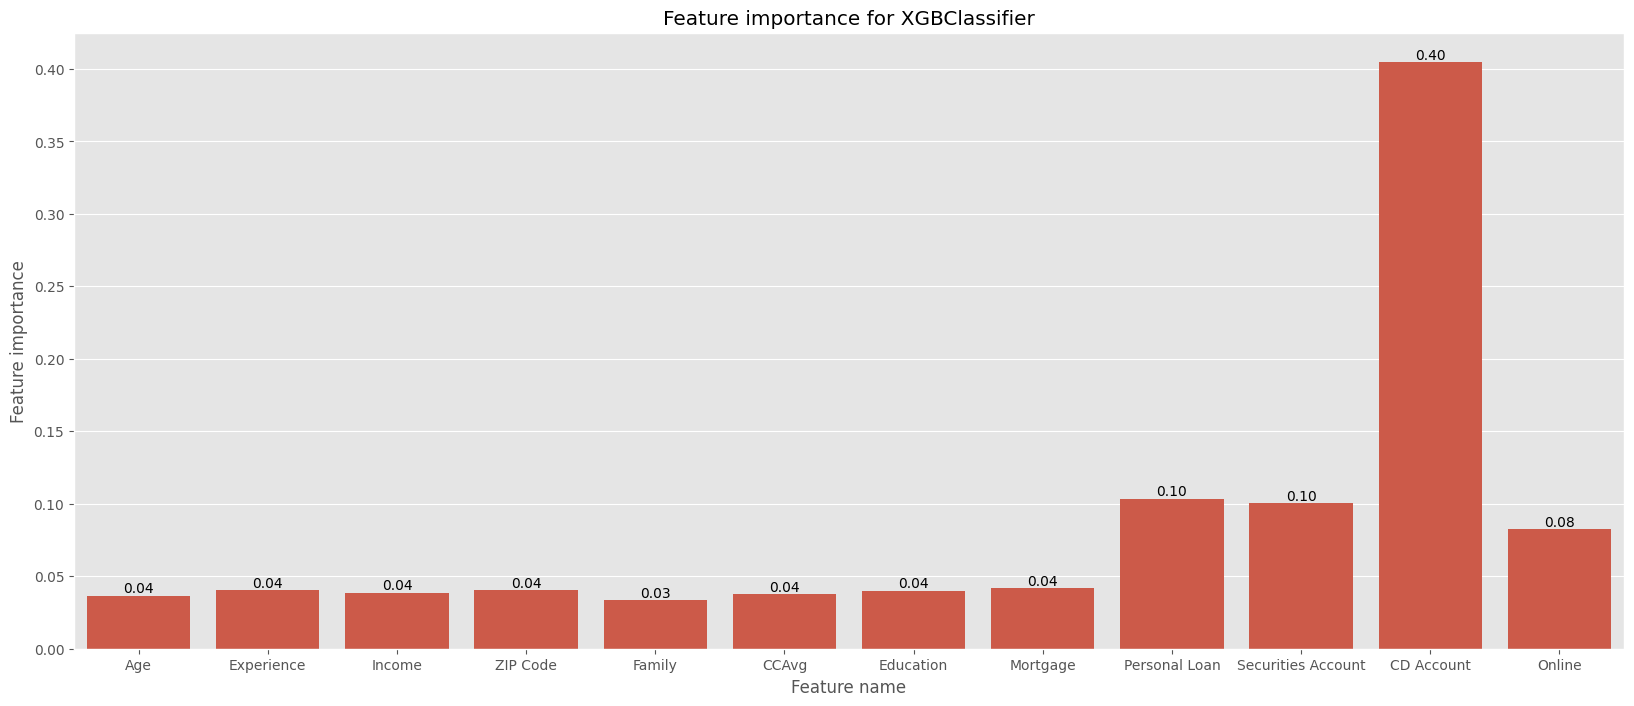

In [ ]:
plt.figure(figsize=(20, 8))

barplot = sns.barplot(x=trained_models["XGBClassifier"].feature_names_in_,
                      y=trained_models["XGBClassifier"].feature_importances_)

for p in barplot.patches:
    h = p.get_height()
    barplot.text(p.get_x()+(p.get_width()/2), h, f"{h:.2f}", ha="center", va="bottom")

barplot.set_xlabel("Feature name")
barplot.set_ylabel("Feature importance")
barplot.set_title("Feature importance for XGBClassifier")

plt.show()

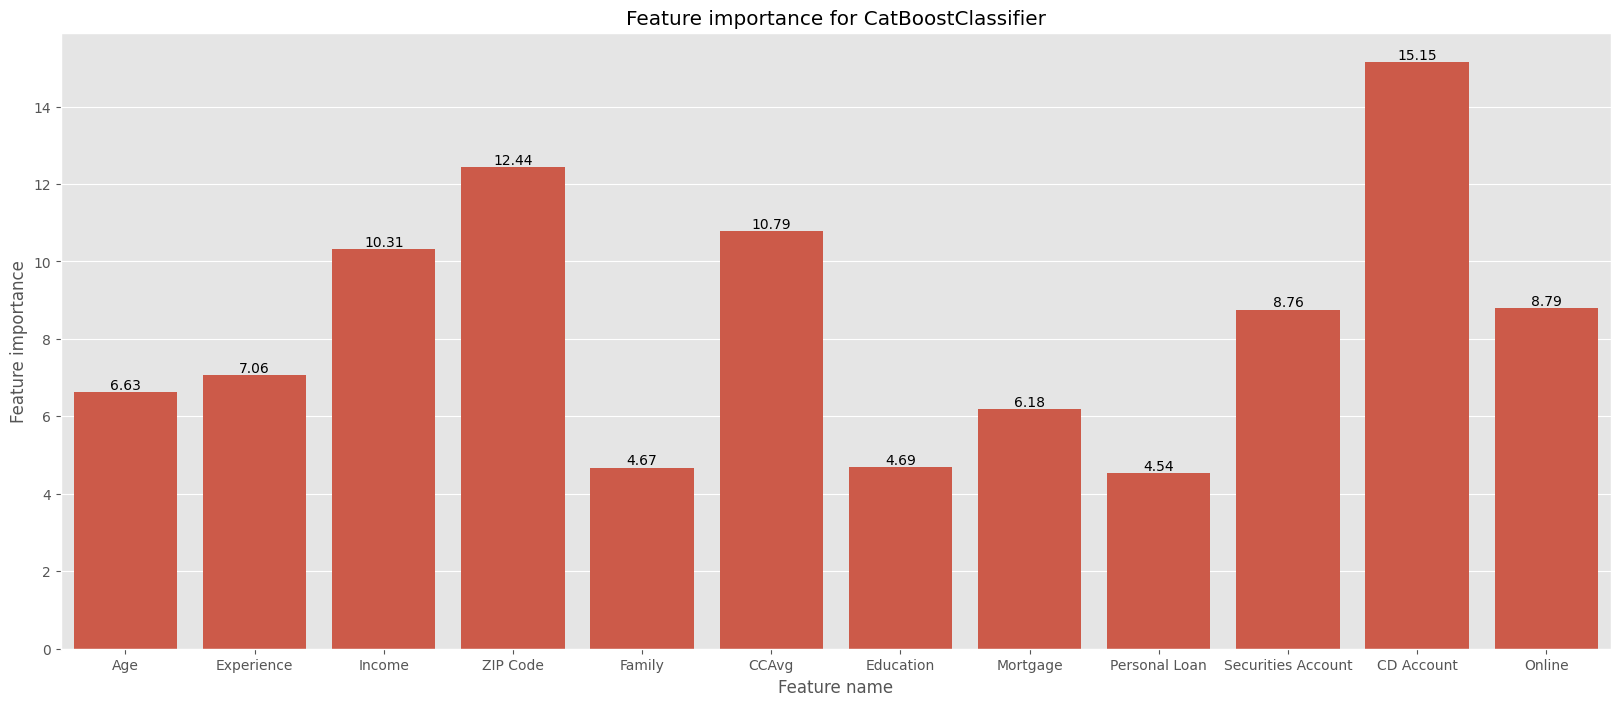

In [ ]:
plt.figure(figsize=(20, 8))

barplot = sns.barplot(y=trained_models["CatBoostClassifier"].feature_importances_,
                      x=trained_models["CatBoostClassifier"].feature_names_)

for p in barplot.patches:
    h = p.get_height()
    barplot.text(p.get_x()+(p.get_width()/2), h, f"{h:.2f}", ha="center", va="bottom")

barplot.set_xlabel("Feature name")
barplot.set_ylabel("Feature importance")
barplot.set_title("Feature importance for CatBoostClassifier")

plt.show()

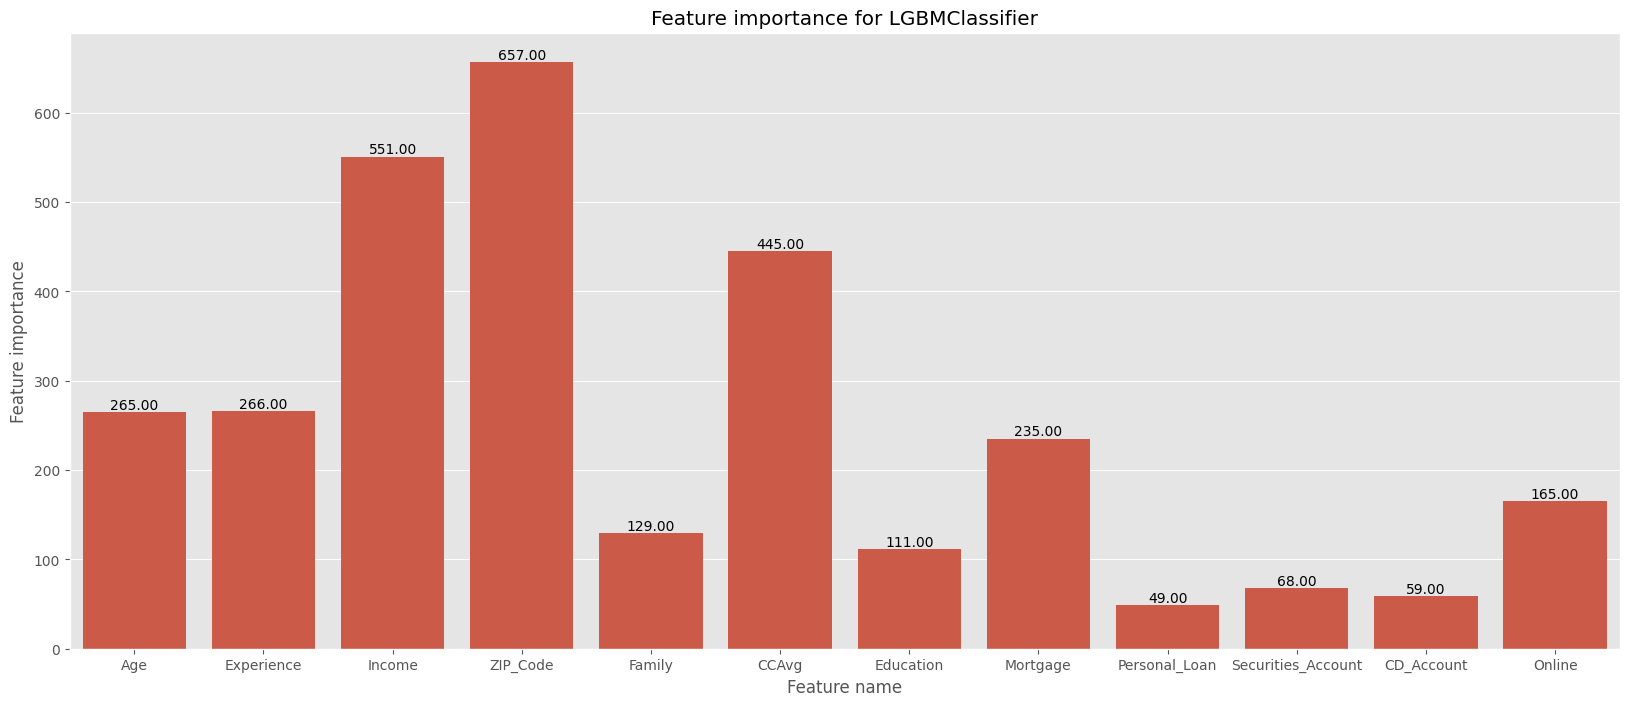

In [ ]:
plt.figure(figsize=(20, 8))

barplot = sns.barplot(y=trained_models["LGBMClassifier"].feature_importances_,
                      x=trained_models["LGBMClassifier"].feature_name_)

for p in barplot.patches:
    h = p.get_height()
    barplot.text(p.get_x()+(p.get_width()/2), h, f"{h:.2f}", ha="center", va="bottom")

barplot.set_xlabel("Feature name")
barplot.set_ylabel("Feature importance")
barplot.set_title("Feature importance for LGBMClassifier")

plt.show()

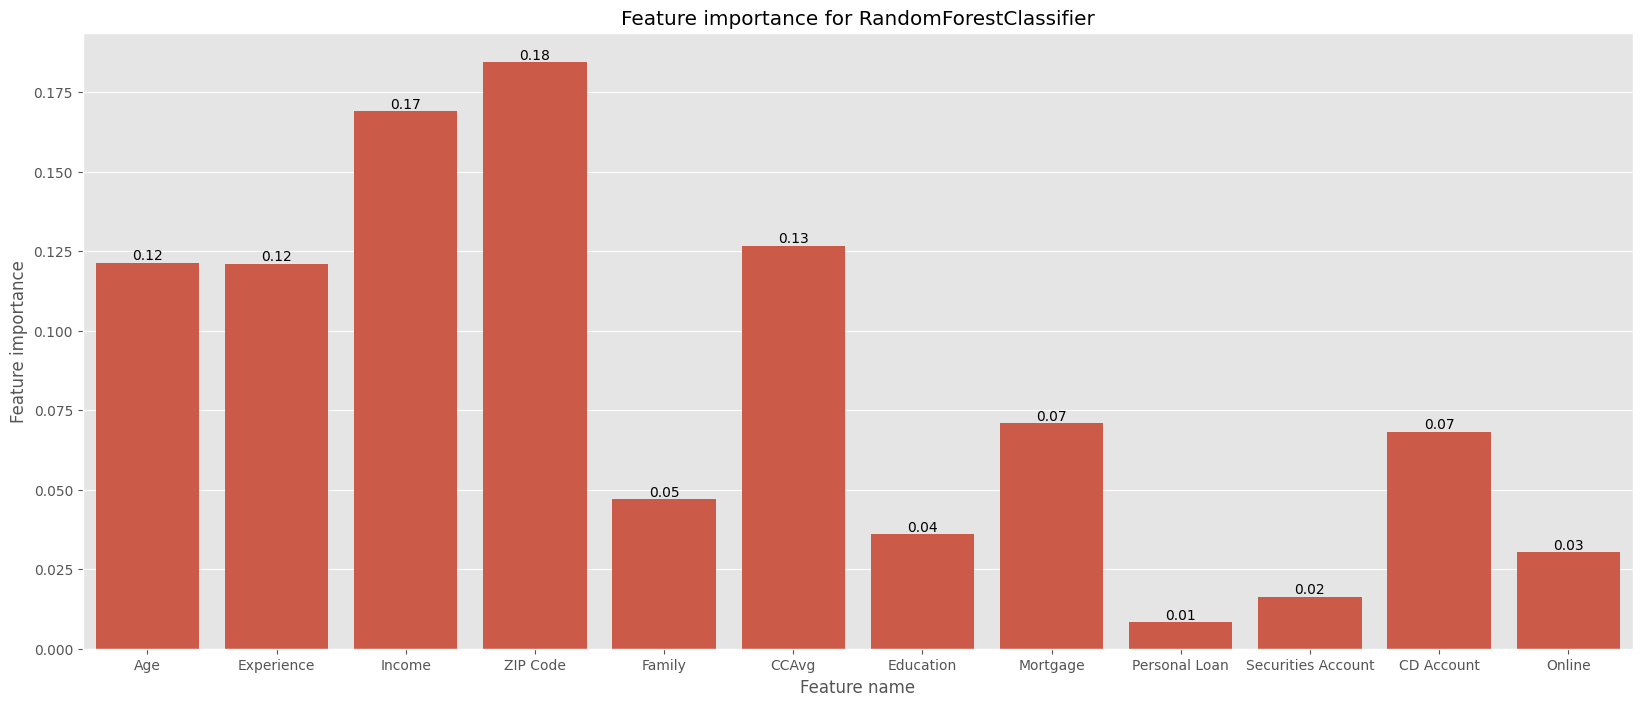

In [ ]:
plt.figure(figsize=(20, 8))

barplot = sns.barplot(y=trained_models["RandomForestClassifier"].feature_importances_,
                      x=trained_models["RandomForestClassifier"].feature_names_in_)

for p in barplot.patches:
    h = p.get_height()
    barplot.text(p.get_x()+(p.get_width()/2), h, f"{h:.2f}", ha="center", va="bottom")

barplot.set_xlabel("Feature name")
barplot.set_ylabel("Feature importance")
barplot.set_title("Feature importance for RandomForestClassifier")

plt.show()

### Stacking

In [ ]:
estimators = [("RandomForestClassifier", ensemble.RandomForestClassifier()),
              ("GaussianNB", naive_bayes.GaussianNB()),
              ("XGBClassifier", XGBClassifier(verbosity=0)),
              ("KNeighborsClassifier", neighbors.KNeighborsClassifier()),
              ("CatBoostClassifier", CatBoostClassifier(silent=True)),
              ("LGBMClassifier", LGBMClassifier(verbosity=-1))]

final_estimator = linear_model.LogisticRegression()

In [ ]:
@timer
def stack_model(X, y, X_val, y_val, model, estimators, final_estimator, n_splits):
    model_ = model(estimators=estimators, final_estimator=final_estimator, cv=n_splits)
    kfold = model_selection.StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)

    pred_per_fold = pd.DataFrame()
    for idx, (train_idx, test_idx) in tqdm(enumerate(kfold.split(X, y)), total=n_splits, desc=f"Training {model.__name__}"):
            xtrain, xtest = X.iloc[train_idx], X.iloc[test_idx]
            ytrain, ytest = y.iloc[train_idx], y.iloc[test_idx]

            model_.fit(xtrain, ytrain)

            pred_per_fold[f"fold {idx}"] = model_.predict(X_val)

    final_pred = pred_per_fold.mode(axis=1)[0]

    print(f"Accuracy score: {metrics.accuracy_score(y_val.reset_index(drop=True), final_pred)}")

    return model_

In [ ]:
s_c = stack_model(x_train, y_train, x_test, y_test, ensemble.StackingClassifier, estimators, final_estimator, 5)

Training StackingClassifier: 100%|██████████| 5/5 [01:58<00:00, 23.71s/it]

Accuracy score: 0.808
Execution time: 118.66654968261719


## Oversampling the data

In [ ]:
@timer
def Objective(trials, X, y, algorithm):
    param_1 = {"k_neighbors": trials.suggest_int("k_neighbors", 1, 10)}

    kfold = model_selection.StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    X_upsampled, y_upsampled = SMOTE(**param_1, n_jobs=-1).fit_resample(X, y)

    acc_score_per_fold = []
    for (train_idx, test_idx) in tqdm(kfold.split(X_upsampled, y_upsampled), total=5):
            xtrain, xtest = X_upsampled.iloc[train_idx], X_upsampled.iloc[test_idx]
            ytrain, ytest = y_upsampled.iloc[train_idx], y_upsampled.iloc[test_idx]

            algorithm.fit(xtrain, ytrain)

            val_pred = algorithm.predict(xtest)

            acc_score_per_fold.append(metrics.accuracy_score(ytest, val_pred))

    return np.mean(acc_score_per_fold)

algo = ensemble.StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=5)
partial_func = partial(Objective, X=X, y=y, algorithm=algo)
study = create_study(direction="maximize")

[I 2024-01-17 04:13:29,905] A new study created in memory with name: no-name-499a0e83-3b32-4c54-a95f-dc6a3c971915


In [ ]:
study.optimize(partial_func, n_trials=10)

100%|██████████| 5/5 [03:35<00:00, 43.02s/it]
[I 2024-01-17 04:17:05,125] Trial 0 finished with value: 0.8038243626062321 and parameters: {'k_neighbors': 2}. Best is trial 0 with value: 0.8038243626062321.


Execution time: 215.20153045654297


100%|██████████| 5/5 [03:24<00:00, 40.93s/it]
[I 2024-01-17 04:20:29,853] Trial 1 finished with value: 0.7971671388101983 and parameters: {'k_neighbors': 6}. Best is trial 0 with value: 0.8038243626062321.


Execution time: 204.7231433391571


100%|██████████| 5/5 [03:20<00:00, 40.06s/it]
[I 2024-01-17 04:23:50,210] Trial 2 finished with value: 0.801558073654391 and parameters: {'k_neighbors': 3}. Best is trial 0 with value: 0.8038243626062321.


Execution time: 200.354154586792


100%|██████████| 5/5 [03:16<00:00, 39.35s/it]
[I 2024-01-17 04:27:07,013] Trial 3 finished with value: 0.805099150141643 and parameters: {'k_neighbors': 1}. Best is trial 3 with value: 0.805099150141643.


Execution time: 196.79917454719543


100%|██████████| 5/5 [03:24<00:00, 40.95s/it]
[I 2024-01-17 04:30:31,852] Trial 4 finished with value: 0.7910764872521246 and parameters: {'k_neighbors': 7}. Best is trial 3 with value: 0.805099150141643.


Execution time: 204.83516907691956


100%|██████████| 5/5 [03:26<00:00, 41.31s/it]
[I 2024-01-17 04:33:58,464] Trial 5 finished with value: 0.7909348441926345 and parameters: {'k_neighbors': 10}. Best is trial 3 with value: 0.805099150141643.


Execution time: 206.60839295387268


100%|██████████| 5/5 [03:22<00:00, 40.59s/it]
[I 2024-01-17 04:37:21,480] Trial 6 finished with value: 0.7916430594900851 and parameters: {'k_neighbors': 6}. Best is trial 3 with value: 0.805099150141643.


Execution time: 203.0080771446228


100%|██████████| 5/5 [03:16<00:00, 39.35s/it]
[I 2024-01-17 04:40:38,278] Trial 7 finished with value: 0.8012747875354108 and parameters: {'k_neighbors': 4}. Best is trial 3 with value: 0.805099150141643.


Execution time: 196.79461693763733


100%|██████████| 5/5 [03:18<00:00, 39.68s/it]
[I 2024-01-17 04:43:56,757] Trial 8 finished with value: 0.7936260623229462 and parameters: {'k_neighbors': 4}. Best is trial 3 with value: 0.805099150141643.


Execution time: 198.4745762348175


100%|██████████| 5/5 [03:18<00:00, 39.71s/it]
[I 2024-01-17 04:47:15,396] Trial 9 finished with value: 0.7946175637393769 and parameters: {'k_neighbors': 6}. Best is trial 3 with value: 0.805099150141643.


Execution time: 198.6351306438446


In [ ]:
x_upsampled, y_upsampled = SMOTE(**study.best_params, n_jobs=-1).fit_resample(X, y)

print(x_upsampled.shape)

(7060, 12)


In [ ]:
xtra_up, xtes_up, ytra_up, ytes_up = model_selection.train_test_split(x_upsampled, y_upsampled, test_size=0.05, random_state=0)

In [ ]:
s_c = stack_model(xtra_up, ytra_up, xtes_up, ytes_up, ensemble.StackingClassifier, estimators, final_estimator, 5)

Training StackingClassifier: 100%|██████████| 5/5 [03:08<00:00, 37.61s/it]

Accuracy score: 0.8073654390934845
Execution time: 188.20084142684937


### Clustering

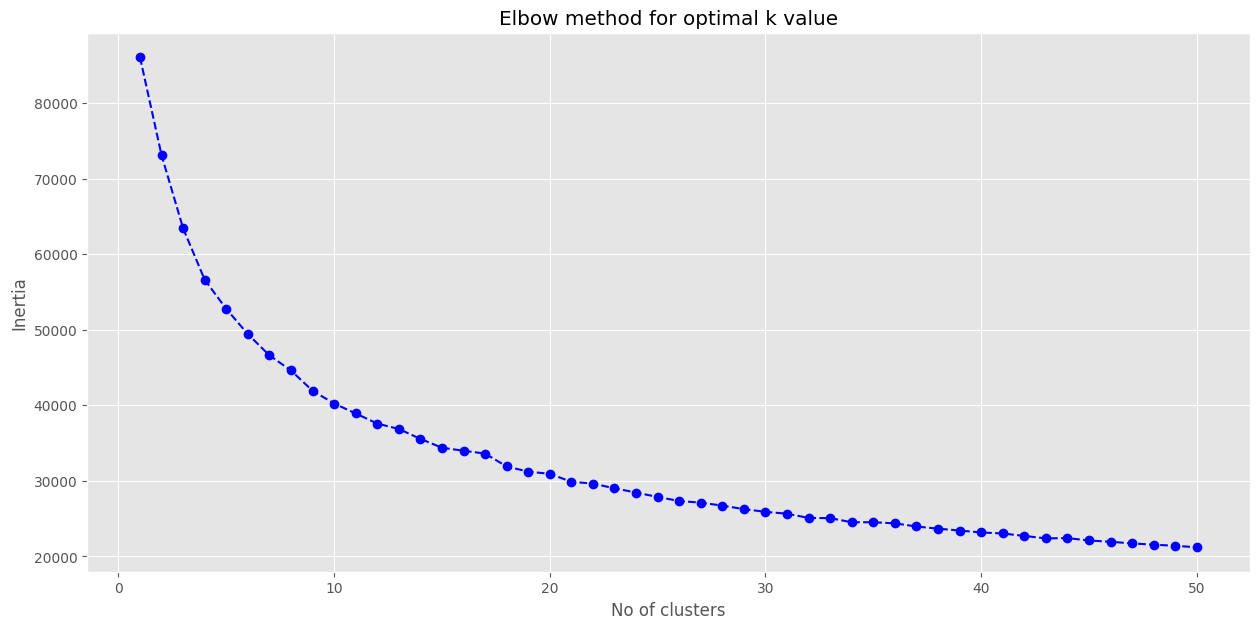

In [ ]:
# Elbow method
inertia = []
for k in range(1, 51):
    kmean = cluster.KMeans(n_clusters=k, random_state=0)
    kmean.fit(x_upsampled)
    inertia.append(kmean.inertia_)

plt.figure(figsize=(15, 7))
plt.plot(range(1, 51), inertia, color="b", marker="o", ls="--")
plt.xlabel("No of clusters")
plt.ylabel("Inertia")
plt.title("Elbow method for optimal k value")
plt.show()

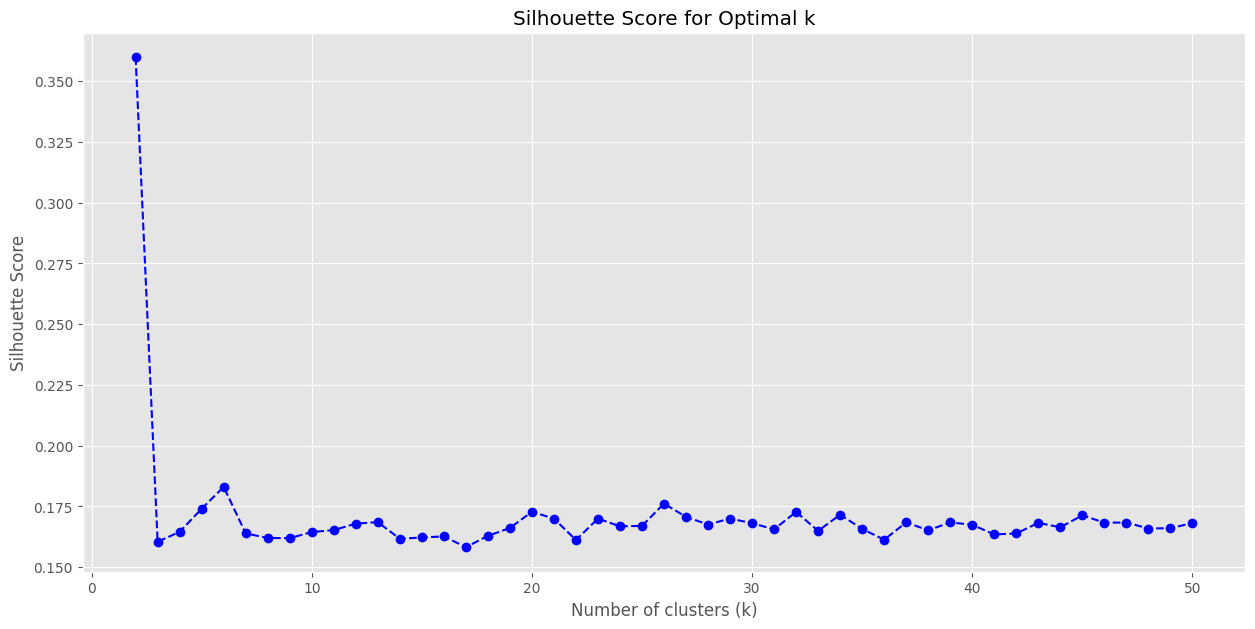

In [ ]:
# Silhouette_scores

silhouette_scores = []

for k in range(2, 51):
    kmean = cluster.KMeans(n_clusters=k, random_state=0)
    kmean.fit(x_upsampled)
    silhouette_scores.append(metrics.silhouette_score(x_upsampled, kmean.labels_))

# Plotting silhouette scores
plt.figure(figsize=(15, 7))
plt.plot(range(2, 51), silhouette_scores, color="b", marker="o", ls="--")
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

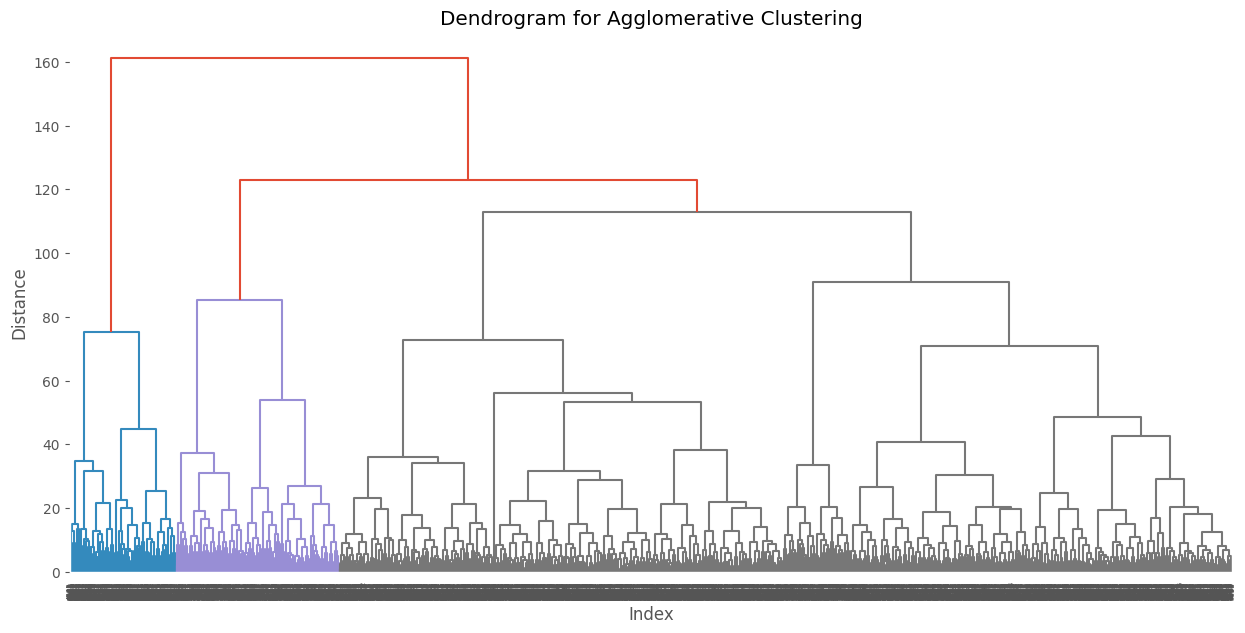

In [ ]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram

# Get the linkage of each data points
linkage_matrix = linkage(x_upsampled, method='ward')

# Plotting the dendrogram
plt.figure(figsize=(15, 7))
# Plot the dendogram of the linkage
dendrogram(linkage_matrix, leaf_rotation=90)
plt.xlabel('Index')
plt.ylabel('Distance')
plt.title('Dendrogram for Agglomerative Clustering')
plt.show()

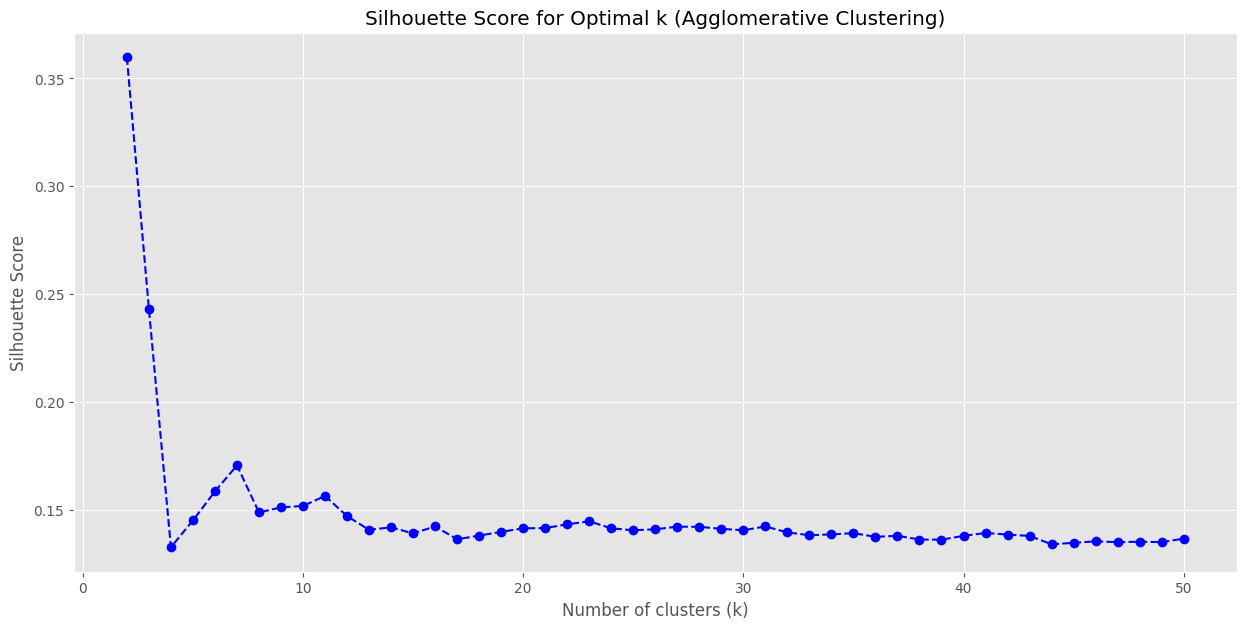

In [ ]:
# Silhouette_scores for AgglomerativeClustering

silhouette_scores = []

for k in range(2, 51):
    ac = cluster.AgglomerativeClustering(n_clusters=k)
    ac.fit(x_upsampled)
    silhouette_scores.append(metrics.silhouette_score(x_upsampled, ac.labels_))

# Plotting silhouette scores
plt.figure(figsize=(15, 7))
plt.plot(range(2, 51), silhouette_scores, color="b", marker="o", ls="--")
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k (Agglomerative Clustering)')
plt.show()

In [ ]:
coph_coeff, _ = cophenet(linkage_matrix, pdist(x_upsampled))
threshold = .80

if coph_coeff >= threshold:
    print(f'Cophenetic Correlation Coefficient: {coph_coeff}')
else:
    print("AgglomerativeClustering did not fit well to the dataset")

AgglomerativeClustering did not fit well to the dataset


In [ ]:
@timer
def N_Clusters_Optimizer(trials, X, y):
    data = X.copy()
    param = {"n_clusters":trials.suggest_int("n_clusters", 1, 500)}
    kmean = cluster.KMeans(**param)
    data["cluster"] = kmean.fit_predict(data)

    kfold = model_selection.StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    algo = ensemble.StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=5)

    acc_score_per_fold = []
    for (train_idx, test_idx) in tqdm(kfold.split(data, y), total=5, desc="Training StackingClassifier"):
        xtrain, xtest = data.iloc[train_idx], data.iloc[test_idx]
        ytrain, ytest = y.iloc[train_idx], y.iloc[test_idx]

        algo.fit(xtrain, ytrain)

        acc_score_per_fold.append(metrics.accuracy_score(ytest, algo.predict(xtest)))

    return np.mean(acc_score_per_fold)

n_cluster_func = partial(N_Clusters_Optimizer, X=x_upsampled, y=y_upsampled)

n_cluster_study = create_study(direction="maximize")

[I 2024-01-17 04:59:29,968] A new study created in memory with name: no-name-84f4b498-49a8-4b5a-96b5-ebab58a64ec6


In [ ]:
n_cluster_study.optimize(n_cluster_func, n_trials=10)

Training StackingClassifier: 100%|██████████| 5/5 [03:32<00:00, 42.57s/it]
[I 2024-01-17 05:03:16,145] Trial 0 finished with value: 0.8104815864022663 and parameters: {'n_clusters': 483}. Best is trial 0 with value: 0.8104815864022663.


Execution time: 226.15905857086182


Training StackingClassifier: 100%|██████████| 5/5 [03:33<00:00, 42.63s/it]
[I 2024-01-17 05:06:56,891] Trial 1 finished with value: 0.8175637393767705 and parameters: {'n_clusters': 362}. Best is trial 1 with value: 0.8175637393767705.


Execution time: 220.74231958389282


Training StackingClassifier: 100%|██████████| 5/5 [03:16<00:00, 39.37s/it]
[I 2024-01-17 05:10:17,373] Trial 2 finished with value: 0.810056657223796 and parameters: {'n_clusters': 150}. Best is trial 1 with value: 0.8175637393767705.


Execution time: 200.479070186615


Training StackingClassifier: 100%|██████████| 5/5 [03:19<00:00, 39.99s/it]
[I 2024-01-17 05:13:44,378] Trial 3 finished with value: 0.8148725212464589 and parameters: {'n_clusters': 192}. Best is trial 1 with value: 0.8175637393767705.


Execution time: 206.9976990222931


Training StackingClassifier: 100%|██████████| 5/5 [03:24<00:00, 40.91s/it]
[I 2024-01-17 05:17:16,237] Trial 4 finished with value: 0.8106232294617565 and parameters: {'n_clusters': 218}. Best is trial 1 with value: 0.8175637393767705.


Execution time: 211.855544090271


Training StackingClassifier: 100%|██████████| 5/5 [03:33<00:00, 42.73s/it]
[I 2024-01-17 05:20:56,378] Trial 5 finished with value: 0.8145892351274788 and parameters: {'n_clusters': 476}. Best is trial 1 with value: 0.8175637393767705.


Execution time: 220.13486194610596


Training StackingClassifier: 100%|██████████| 5/5 [03:22<00:00, 40.53s/it]
[I 2024-01-17 05:24:26,451] Trial 6 finished with value: 0.8144475920679888 and parameters: {'n_clusters': 227}. Best is trial 1 with value: 0.8175637393767705.


Execution time: 210.06234526634216


Training StackingClassifier: 100%|██████████| 5/5 [03:28<00:00, 41.60s/it]
[I 2024-01-17 05:27:59,652] Trial 7 finished with value: 0.8135977337110483 and parameters: {'n_clusters': 257}. Best is trial 1 with value: 0.8175637393767705.


Execution time: 213.19874382019043


Training StackingClassifier: 100%|██████████| 5/5 [03:29<00:00, 41.84s/it]
[I 2024-01-17 05:31:36,783] Trial 8 finished with value: 0.8114730878186969 and parameters: {'n_clusters': 323}. Best is trial 1 with value: 0.8175637393767705.


Execution time: 217.12375259399414


Training StackingClassifier: 100%|██████████| 5/5 [03:31<00:00, 42.38s/it]
[I 2024-01-17 05:35:14,801] Trial 9 finished with value: 0.8154390934844192 and parameters: {'n_clusters': 377}. Best is trial 1 with value: 0.8175637393767705.


Execution time: 218.0149540901184


In [ ]:
n_cluster_study.best_params

{'n_clusters': 362}


### PCA
---



In [ ]:
pca = decomposition.PCA(n_components=3)

pca_result = pd.DataFrame(pca.fit_transform(x_upsampled), columns=[f"PC{i}" for i in range(1, 4)])

pca_result.head()

,PC1,PC2,PC3
0,-0.129406,-2.472735,1.400543
1,-0.611691,-0.121786,1.047712
2,-1.255566,-0.924661,-0.209937
3,0.116763,-1.436879,-0.998828
4,-1.055631,-1.612734,0.249650


In [ ]:
pca.explained_variance_ratio_

array([0.19946148, 0.16262053, 0.12882065])

### Observation:
* The first principal component explains approximately 19.69% of the total variance in the dataset.
* The second principal component explains approximately 16.23% of the total variance.
* The third principal component explains approximately 12.82% of the total variance.

In [ ]:
X_tra_pca, X_tes_pca, y_tra_pca, y_tes_pca  = model_selection.train_test_split(pca_result, y_upsampled, test_size=0.05, random_state=0)

In [ ]:
s_c_pca = stack_model(X_tra_pca, y_tra_pca, X_tes_pca, y_tes_pca, ensemble.StackingClassifier, estimators, final_estimator, 5)

Training StackingClassifier: 100%|██████████| 5/5 [02:21<00:00, 28.37s/it]

Accuracy score: 0.6827195467422096
Execution time: 141.94526195526123


In [ ]:
pca = decomposition.PCA(.95)

pca_result = pd.DataFrame(pca.fit_transform(x_upsampled))

pca_result.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.129406,-2.472735,1.400543,-0.347840,1.837875,-2.224208,1.007648,1.231250,1.182976,0.619826
1,-0.611691,-0.121786,1.047712,-0.675526,2.256419,-1.764998,0.868797,1.481250,1.011788,0.708977
2,-1.255566,-0.924661,-0.209937,-0.918722,1.072700,-0.134415,-0.232865,-0.927852,-1.271098,0.348799
3,0.116763,-1.436879,-0.998828,-0.278730,1.271690,0.592421,0.109604,-0.846294,-0.345048,-0.320416
4,-1.055631,-1.612734,0.249650,1.073060,0.358497,-0.796418,0.838490,0.820487,-0.542362,-0.306471


In [ ]:
X_tra_pca, X_tes_pca, y_tra_pca, y_tes_pca  = model_selection.train_test_split(pca_result, y_upsampled, test_size=0.05, random_state=0)

In [ ]:
s_c_pca = stack_model(X_tra_pca, y_tra_pca, X_tes_pca, y_tes_pca, ensemble.StackingClassifier, estimators, final_estimator, 5)

Training StackingClassifier: 100%|██████████| 5/5 [04:12<00:00, 50.49s/it]

Accuracy score: 0.8130311614730878
Execution time: 252.60127925872803


In [ ]:
def Pca_Optimizer(trials, X, y):
  param = {"n_components": trials.suggest_float("n_components", 0, 1)}
  pca = decomposition.PCA(**param)
  pca_result = pd.DataFrame(pca.fit_transform(X))

  kfold = model_selection.StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
  algo = ensemble.StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=5)

  acc_score_per_fold = []
  for (train_idx, test_idx) in tqdm(kfold.split(pca_result, y), total=5, desc="Training StackingClassifier"):
      xtrain, xtest = pca_result.iloc[train_idx], pca_result.iloc[test_idx]
      ytrain, ytest = y.iloc[train_idx], y.iloc[test_idx]

      algo.fit(xtrain, ytrain)

      acc_score_per_fold.append(metrics.accuracy_score(ytest, algo.predict(xtest)))

  return np.mean(acc_score_per_fold)

pca_func = partial(Pca_Optimizer, X=x_upsampled, y=y_upsampled)

pca_study = create_study(direction="maximize")

[I 2024-01-17 05:41:49,590] A new study created in memory with name: no-name-80628cd1-11f3-459a-8619-898b7fb4bdc5


In [ ]:
pca_study.optimize(func=pca_func, n_trials=15)

Training StackingClassifier: 100%|██████████| 5/5 [02:11<00:00, 26.36s/it]
[I 2024-01-17 05:44:01,403] Trial 0 finished with value: 0.588385269121813 and parameters: {'n_components': 0.3144098609103462}. Best is trial 0 with value: 0.588385269121813.
Training StackingClassifier: 100%|██████████| 5/5 [03:43<00:00, 44.64s/it]
[I 2024-01-17 05:47:44,620] Trial 1 finished with value: 0.791643059490085 and parameters: {'n_components': 0.8712494808358596}. Best is trial 1 with value: 0.791643059490085.
Training StackingClassifier: 100%|██████████| 5/5 [02:02<00:00, 24.52s/it]
[I 2024-01-17 05:49:47,255] Trial 2 finished with value: 0.5366855524079319 and parameters: {'n_components': 0.14982572683879336}. Best is trial 1 with value: 0.791643059490085.
Training StackingClassifier: 100%|██████████| 5/5 [03:10<00:00, 38.06s/it]
[I 2024-01-17 05:52:57,590] Trial 3 finished with value: 0.7711048158640226 and parameters: {'n_components': 0.6336715192131745}. Best is trial 1 with value: 0.7916430594

## Eddy